# Introduction: Modeling

In this notebook, we will use the calculated feature matrices to train and test a machine learning model. Our objective is a model that can predict, on the first of the month, which customers will churn during the next 30 days.

In [1]:
import pandas as pd
import numpy as np

PARTITION_DIR = 's3://customer-churn-spark'

In [55]:
label_times = pd.read_csv(f'{PARTITION_DIR}/p0/MS-30_labels.csv')
label_times['cutoff_time'] = pd.to_datetime(label_times['cutoff_time'])
label_times['customer_id'] = label_times['msno'].replace({customer: idx + 1 for idx, customer in enumerate(label_times['msno'].unique())})
label_times[['customer_id', 'cutoff_time', 'label']].iloc[6:14]

,customer_id,cutoff_time,label
6,1,2016-07-01,0.0
7,1,2016-08-01,0.0
8,1,2016-09-01,0.0
9,1,2016-10-01,0.0
10,1,2016-11-01,0.0
11,1,2016-12-01,0.0
12,1,2017-01-01,1.0
13,1,2017-02-01,0.0


In [56]:
label_times[['customer_id', 'cutoff_time', 'label']].iloc[100:115]

,customer_id,cutoff_time,label
100,14,2016-08-01,1.0
101,14,2016-09-01,0.0
102,14,2016-10-01,0.0
103,15,2015-06-01,0.0
104,16,2015-05-01,0.0
105,16,2015-06-01,0.0
106,16,2015-07-01,0.0
107,16,2015-08-01,0.0
108,16,2015-09-01,0.0
109,16,2015-10-01,0.0


In [57]:
# label_times[['customer_id', 'cutoff_time', 'label']].sample(5000).sort_values(['customer_id', 'cutoff_time'])

In [2]:
p0_fm = pd.read_csv(f'{PARTITION_DIR}/p0/MS-30_feature_matrix.csv')
p0_fm.head()

,msno,time,city,bd,registered_via,gender,SUM(logs.num_25),SUM(logs.num_50),SUM(logs.num_75),SUM(logs.num_985),...,WEEKEND(LAST(transactions.membership_expire_date)),DAY(LAST(logs.date)),DAY(LAST(transactions.transaction_date)),DAY(LAST(transactions.membership_expire_date)),MONTH(LAST(logs.date)),MONTH(LAST(transactions.transaction_date)),MONTH(LAST(transactions.membership_expire_date)),label,days_to_churn,churn_date
0,+9zx0+mA3IZQLyjmU88qbfqJ0q9okIfYZnDI6FqaN2o=,2015-01-01,1.0,0.0,7.0,NaN,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
1,+sZCvwt5NmFw4uE185pBid4cOxtXTHovIyPFqchulQg=,2015-01-01,1.0,0.0,7.0,NaN,0.0,0.0,0.0,0.0,...,1.0,NaN,1.0,1.0,NaN,1.0,2.0,0.0,364.0,0
2,+wzmLe86mMBeoIYoPedlt24WVTW6tabsRcaz81ZXBx0=,2015-01-01,1.0,0.0,7.0,NaN,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
3,/9+HJnqEryBbuH598zKqa8zb1Eypy927imqI9IWhJTk=,2015-01-01,8.0,29.0,9.0,male,3.0,0.0,0.0,0.0,...,0.0,1.0,NaN,NaN,1.0,NaN,NaN,0.0,457.0,0
4,/BAK3DkUpoUESh4t8qlWs16yop+sG3i3oPYDpv5uGI0=,2015-01-01,13.0,21.0,9.0,male,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN


In [65]:
import random
columns = random.sample(list(p0_fm.columns), 10)

In [58]:
example = p0_fm.copy().rename(columns = {'time': 'cutoff_time'})
example['customer_id'] = example['msno'].replace({customer: idx + 1 for idx, customer in enumerate(example['msno'].unique())})
example[['customer_id', 'time'] + columns]

,msno,cutoff_time,city,bd,registered_via,gender,SUM(logs.num_25),SUM(logs.num_50),SUM(logs.num_75),SUM(logs.num_985),...,DAY(LAST(logs.date)),DAY(LAST(transactions.transaction_date)),DAY(LAST(transactions.membership_expire_date)),MONTH(LAST(logs.date)),MONTH(LAST(transactions.transaction_date)),MONTH(LAST(transactions.membership_expire_date)),label,days_to_churn,churn_date,customer_id
10774,A95UIAd+m8UuPPvGw+8+rO5l1k3qYWZMzooWPs7mTUQ=,2016-02-01,13.0,26.0,9.0,male,285.0,25.0,19.0,15.0,...,1.0,13.0,18.0,2.0,1.0,2.0,0.0,NaN,NaN,1265
13903,5uwhhH2XqhR8p8E5Ve8/3vXzGlQwJ51RlJSIxaGQEUM=,2016-05-01,13.0,29.0,9.0,female,969.0,486.0,353.0,316.0,...,1.0,16.0,15.0,5.0,4.0,5.0,0.0,NaN,NaN,62
5782,5zhRt6JuXrF0UaUGSh9Ug0hVL7y+YDSPAMlb6Bi3cW4=,2015-09-01,4.0,34.0,9.0,male,220.0,73.0,52.0,48.0,...,1.0,31.0,30.0,9.0,8.0,9.0,0.0,0.0,0,590
22208,RxAb4IGc+5Jwgy8U6NDy5JpbGuuNriQnROs1RDGQsSs=,2016-12-01,5.0,24.0,9.0,female,2586.0,680.0,454.0,417.0,...,1.0,30.0,22.0,12.0,11.0,1.0,0.0,0.0,0,258
22739,xebVNeg1SyHxTWuJlOLlCuZCOqQwhZ03+WZumyDaBzc=,2016-12-01,1.0,0.0,7.0,NaN,111.0,51.0,38.0,41.0,...,1.0,17.0,17.0,12.0,11.0,12.0,0.0,NaN,NaN,1962
6906,Mj+13+GfPvWWQSgDMbw/JW8e9U7XZ3bu75brFHgox+Y=,2015-10-01,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1198
21748,0sqC5X4VAnWVwTo4lDlDDQvz77N8HtnJE6wZwzaqlHM=,2016-12-01,1.0,0.0,7.0,NaN,331.0,109.0,84.0,143.0,...,1.0,16.0,16.0,12.0,11.0,12.0,0.0,NaN,NaN,1444
6028,OfN8uUHpNWYRuveCr2hEWKUaGcrf1FC5r20KeZGIUAk=,2015-09-01,1.0,0.0,7.0,NaN,0.0,0.0,0.0,0.0,...,NaN,7.0,7.0,NaN,8.0,9.0,0.0,NaN,NaN,217
11049,R/AH1J6ENIjkf9LMNRvXPN/SmB1SIW53xfILQhjLoGU=,2016-02-01,1.0,0.0,7.0,NaN,1229.0,111.0,104.0,56.0,...,1.0,19.0,19.0,2.0,1.0,2.0,0.0,NaN,NaN,994
21366,iGuoexsdr0mrPHJC01rjAwYi2KNYa4AqoLHGqfEJOo4=,2016-11-01,1.0,0.0,7.0,NaN,4136.0,735.0,439.0,475.0,...,30.0,27.0,28.0,10.0,10.0,11.0,0.0,NaN,NaN,398


In [66]:
example[['customer_id', 'cutoff_time'] + columns].head()

,customer_id,cutoff_time,SUM(transactions.actual_amount_paid WHERE is_cancel = 0),MIN(logs.num_100),PERCENT_TRUE(transactions.WEEKEND(transaction_date) WHERE is_auto_renew = 0),PERCENT_TRUE(transactions.WEEKEND(membership_expire_date) WHERE is_auto_renew = 1),DAY(LAST(transactions.membership_expire_date)),TIME_SINCE_LAST(logs.date),ALL(transactions.is_cancel WHERE is_auto_renew = 1),SUM(transactions.payment_plan_days WHERE is_cancel = 0),MEAN(transactions.actual_amount_paid WHERE is_auto_renew = 1),TIME_SINCE_LAST(transactions.transaction_date)
0,1,2015-01-01,0.0,NaN,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN
1,2,2015-01-01,149.0,NaN,0.0,1.0,1.0,NaN,False,30.0,149.0,0.0
2,3,2015-01-01,0.0,NaN,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN
3,4,2015-01-01,0.0,37.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN
4,5,2015-01-01,0.0,NaN,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN


In [3]:
# import findspark
# findspark.init('/usr/local/spark-2.3.1-bin-hadoop2.7/')
# import pyspark

# sc = pyspark.SparkContext(master = 'spark://ip-172-31-23-133.ec2.internal:7077', appName = 'retrieval')
# sc.stop()

## Function to Retrieve Data

In [4]:
def retrieve_data(partition_num, label_type='MS-30'):
    return pd.read_csv(f'{PARTITION_DIR}/p{partition_num}/{label_type}_feature_matrix.csv', low_memory=False)

In [5]:
import random

N_PARTITIONS = 1000
partitions = list(range(N_PARTITIONS))

The next cell retrieves a number of feature matrices for training and for testing. This could be done in parallel, but does not take very long to do sequentially. 

In [15]:
random.seed(50)

# Set number of train and testing feature matrices
fms_to_get = 10
test_fms_to_get = 5

# Choose random sample of partitions
ps = random.sample(list(range(900)), fms_to_get + test_fms_to_get)

# Separate into training and testing
test_p = ps[:test_fms_to_get]
train_p = ps[test_fms_to_get:]


train_fms = []

for i, p in enumerate(train_p):
    print(f'{round(100 * (i / fms_to_get), 2)}% complete.', end='\r')
    train_fms.append(retrieve_data(p))

feature_matrix = pd.concat(train_fms)
feature_matrix = feature_matrix[~feature_matrix['churn'].isna()]
feature_matrix.shape

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



(131815, 255)

In [16]:
test_fms = []

for i, p in enumerate(test_p):
    print(f'{round(100 * (i / test_fms_to_get), 2)}% complete.', end='\r')
    test_fms.append(retrieve_data(p))

test_feature_matrix = pd.concat(test_fms)
test_feature_matrix = test_feature_matrix[~test_feature_matrix['churn'].isna()]
test_feature_matrix.shape

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


(78409, 255)

In [17]:
test_feature_matrix.head()

,ALL(logs.WEEKEND(date)),ALL(transactions.WEEKEND(membership_expire_date) WHERE is_auto_renew = 0),ALL(transactions.WEEKEND(membership_expire_date) WHERE is_auto_renew = 1),ALL(transactions.WEEKEND(membership_expire_date) WHERE is_cancel = 0),ALL(transactions.WEEKEND(membership_expire_date) WHERE is_cancel = 1),ALL(transactions.WEEKEND(membership_expire_date)),ALL(transactions.WEEKEND(transaction_date) WHERE is_auto_renew = 0),ALL(transactions.WEEKEND(transaction_date) WHERE is_auto_renew = 1),ALL(transactions.WEEKEND(transaction_date) WHERE is_cancel = 0),ALL(transactions.WEEKEND(transaction_date) WHERE is_cancel = 1),...,churn,churn_date,city,days_to_churn,days_to_next_churn,gender,label,msno,registered_via,time
0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,6.0,NaN,719.0,female,NaN,+1EE5ENZKseg97UEcVSOEgz+PSLZDwdy7SQGL7DJXfg=,7.0,2015-01-01
1,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,1.0,NaN,NaN,NaN,NaN,+8wyPWUzU3P1K3l+0CcnSeh+LvMZhoERoY91YqxuK/k=,7.0,2015-01-01
2,NaN,NaN,True,True,NaN,True,NaN,False,False,NaN,...,0.0,NaN,1.0,NaN,NaN,NaN,NaN,+Fsq06gzLyf44RHR1/jgAYv+IMKMP2hYCFwYvUX0+LQ=,7.0,2015-01-01
3,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,13.0,NaN,447.0,male,NaN,+egyQhDfvK1PvkbHy7qEtlHPekvYwIog4YWc/POLorA=,9.0,2015-01-01
4,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,4.0,NaN,NaN,NaN,NaN,+mCpFmfAW2h213mhlSxpAE3HUMM8jNsH5NBR8g//DZw=,7.0,2015-01-01


In [22]:
pd.options.display.max_rows = 500
feature_matrix.dtypes

ALL(logs.WEEKEND(date))                                                                  bool
ALL(transactions.WEEKEND(membership_expire_date) WHERE is_auto_renew = 0)                bool
ALL(transactions.WEEKEND(membership_expire_date) WHERE is_auto_renew = 1)                bool
ALL(transactions.WEEKEND(membership_expire_date) WHERE is_cancel = 0)                    bool
ALL(transactions.WEEKEND(membership_expire_date) WHERE is_cancel = 1)                    bool
ALL(transactions.WEEKEND(membership_expire_date))                                        bool
ALL(transactions.WEEKEND(transaction_date) WHERE is_auto_renew = 0)                      bool
ALL(transactions.WEEKEND(transaction_date) WHERE is_auto_renew = 1)                      bool
ALL(transactions.WEEKEND(transaction_date) WHERE is_cancel = 0)                          bool
ALL(transactions.WEEKEND(transaction_date) WHERE is_cancel = 1)                          bool
ALL(transactions.WEEKEND(transaction_date))                 

In [21]:
bool_cols = [c for c in feature_matrix if 'ALL' in c]

for c in bool_cols:
    feature_matrix[c] = feature_matrix[c].astype(bool)

# Feature Preparation

The next blocks of code get the features ready for machine learning.

First we need to one hot encode the features. After doing this, we align the training and testing dataframes so they have the same columns.

In [23]:
feature_matrix = pd.get_dummies(feature_matrix.set_index('msno').drop(columns = ['time', 'churn_date', 'days_to_churn',
                                                                                 'label', 'days_to_next_churn']))
test_feature_matrix = pd.get_dummies(test_feature_matrix.set_index('msno').drop(columns = ['time']))
feature_matrix, test_feature_matrix = feature_matrix.align(
    test_feature_matrix, join='inner', axis=1)
feature_matrix.shape

(131815, 254)

Now we can extract the labels. There are two different problems: one is a binary classification of whether or not the customer will churn during the month. The other is a regression: how many days are there until the next churn.

In [35]:
y, test_y = np.array(feature_matrix.pop('churn')), np.array(test_feature_matrix.pop('churn'))

y_reg, test_y_reg = np.array(feature_matrix.pop('days_to_next_churn')), np.array(
    test_feature_matrix.pop('days_to_next_churn'))

(array([128802.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,   3013.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

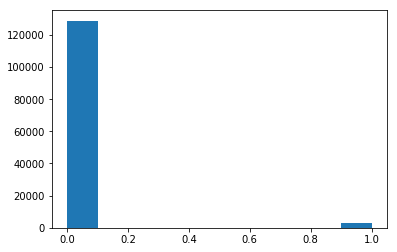

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(y)

### Fill in Missing Values

We can fill in missing values using the median of the column. As an important note, the missing test values are filled in with the median of the corresponding training feature.

In [30]:
feature_matrix = feature_matrix.replace({np.inf: np.nan, -np.inf: np.nan}).\
    fillna(feature_matrix.median()).fillna(0)

In [31]:
test_feature_matrix = test_feature_matrix.replace({np.inf: np.nan, -np.inf: np.nan}).\
    fillna(feature_matrix.median()).fillna(0)

In [32]:
np.any(feature_matrix.isnull()), np.any(np.isinf(feature_matrix))

(False, False)

# Machine Learning

## Baseline Model

We can use a logistic regression in order to see baseline performance on this problem. If the logistic regression works well enough, then there is no need to move to a more complex model.

In [33]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

In [34]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score


def evaluate(model, train, y, test, test_y):
    model.fit(train, y)

    probs = model.predict_proba(test)[:, 1]
    preds = model.predict(test)

    roc = roc_auc_score(test_y, probs)
    name = repr(model).split('(')[0]
    print(f"{name}\n")
    print(f'ROC AUC: {round(roc, 4)}')

    for metric in [precision_score, recall_score, f1_score]:
        print(f'{metric.__name__}: {round(metric(test_y, preds), 4)}')

    return model, preds


model, preds = evaluate(model, feature_matrix, y, test_feature_matrix, test_y)

LogisticRegression

ROC AUC: 0.5273
precision_score: 0.0048
recall_score: 0.0028
f1_score: 0.0035


## More Complex Model

For a better machine learning model, we can move to the Random Forest Classifier. From the results of the logistic regression, this looks to be a non-linear problem which means we should use a model capable of learning a non-linear decision boundary.

In [36]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, max_depth=20, n_jobs=-1)
model, preds = evaluate(model, feature_matrix, y, test_feature_matrix, test_y)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


RandomForestClassifier

ROC AUC: 0.937
precision_score: 0.9329
recall_score: 0.3274
f1_score: 0.4846


In [37]:
fi = pd.DataFrame({'importance': model.feature_importances_}, index=feature_matrix.columns).\
    sort_values('importance', ascending=False)
fi.head()

,importance
"TOTAL_PREVIOUS_MONTH(transactions.actual_amount_paid, membership_expire_date)",0.029003
TIME_SINCE_LAST(transactions.transaction_date),0.027107
TIME_SINCE_LAST(logs.date),0.024329
"TOTAL_PREVIOUS_MONTH(transactions.price_difference, membership_expire_date)",0.019876
DAY(LAST(transactions.membership_expire_date)),0.019584


In [38]:
model = RandomForestClassifier(n_estimators=100, max_depth=20, n_jobs=-1)
model.fit(feature_matrix[['TIME_SINCE_LAST(transactions.transaction_date)',
                          'LAST(transactions.DAY(membership_expire_date))']], np.array(y))

p = model.predict_proba(test_feature_matrix[['TIME_SINCE_LAST(transactions.transaction_date)',
                                             'LAST(transactions.DAY(membership_expire_date))']])[:, 1]
roc_auc_score(np.array(test_y), p)

0.7274510128091647

In [39]:
1 - np.mean(test_y)

0.9772475098521853

In [40]:
feature_matrix.iloc[np.where(y == 1)[
    0]]['TIME_SINCE_LAST(transactions.transaction_date)'].describe() / (3600 * 24)

count      0.034873
mean     205.604713
std      186.954963
min        0.000000
25%       31.000000
50%      148.000000
75%      395.000000
max      757.000000
Name: TIME_SINCE_LAST(transactions.transaction_date), dtype: float64

In [41]:
feature_matrix.iloc[np.where(
    y == 0)[0]]['TIME_SINCE_LAST(transactions.transaction_date)'].describe() / (3600 * 24)

count      1.490764
mean     244.220222
std      222.260674
min        0.000000
25%       34.000000
50%      197.000000
75%      400.000000
max      790.000000
Name: TIME_SINCE_LAST(transactions.transaction_date), dtype: float64

# Confusion Matrix

In [45]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[76583    42]
 [ 1200   584]]


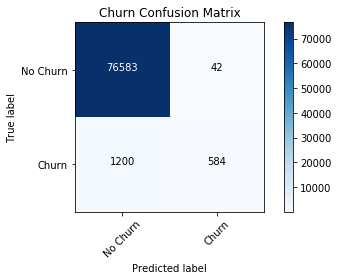

In [46]:
cm = confusion_matrix(test_y, preds)
plot_confusion_matrix(cm, classes = ['No Churn', 'Churn'],
                      title = 'Churn Confusion Matrix')